In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Faster R-CNN Dataset & Model Setup

## 1. Installing and Import Library

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.3 MB/s eta 0:00:00


- Cài đặt thư viện torch_snippets để hỗ trợ xử lý dữ liệu và hiển thị thông tin.  
- Import tất cả các thành phần từ torch_snippets.

In [ ]:
from torch_snippets.torch_loader import Report


- Report helps monitor the training process and model evaluation.

## 2. Import Thư Viện Cần Thiết

In [ ]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
from torchvision.ops import nms
import matplotlib.pyplot as plt

- Torch: The main framework to build a deep model.  
- Pil.image: Support image processing.  
- Dataset, Dataloader: Create and manage data sets.  
- Torchvision.models: contains available computer visual models.  
- FasterRCNNPRedICTor: Definition of predictive layer of Faster R-CNN model.  
- ElementTree (et): processing data from XML file (often used for annotation in the object detection problem).  
- NMS helps to filter out the best box based on Confidence Score 
- Matplotlib: This is the library used to draw charts, graphs in Python.

## 3. Equipment setting (GPU/CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

- Check if there is a GPU, if any, use CUDA, otherwise use the CPU.



## 4. Định Nghĩa Tập Dữ Liệu và Nhãn

In [ ]:
root = '/content/drive/MyDrive/IUH/Computer_Vision/Fruits_RCNN_Object_Detection/data/train_zip/train/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

- Root: The path to the directory contains training data.  
- Labels: List of model labels, including background.  
- Label2Targets: Mapping from label to index integer.  
- Targets2label: Mapping from integer index to the label.  
- Num_classes: The number of layers in the problem of detecting object.

## 5. Photo processing and creating dataset

In [ ]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

- Convert images into Tensor and change the order of color channel to fit the model.

In [ ]:
class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h),
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = '/content/drive/MyDrive/IUH/Computer_Vision/Fruits_RCNN_Object_Detection/data/test_zip/test/'

tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = tr_ds[10]

- Create Fruitsdataset layer to manage image data and annotations.  
- Resize image of fixed size (224, 224), standardize pixel value.  
- Extract label information and bounding box from XML file.  
- Bounding box conversion to Tensor suitable for the model.  
- Definition of collate_fn to process data batching in dataloader.

## 6. Chuẩn Bị Dataloader

In [ ]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 72.5MB/s]


{'loss_classifier': tensor(1.3631, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.5331, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0115, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)}

-Load Faster R-CNN model using Resnet50-FPN.  
- Replace the prediction layer to fit the number of layers in the data set.  
- Create dataloader for training and testing.  
- Batch_size = 4 for training, batch_size = 2 for validation.

## 7. Model training and evaluation

EPOCH: 0.017  trn_loss: 1.973  trn_loc_loss: 1.478  trn_regr_loss: 0.481  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.008  (1.23s - 367.03s remaining)
EPOCH: 0.033  trn_loss: 0.681  trn_loc_loss: 0.458  trn_regr_loss: 0.217  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (2.14s - 319.56s remaining)
EPOCH: 0.050  trn_loss: 0.567  trn_loc_loss: 0.282  trn_regr_loss: 0.277  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (3.03s - 299.63s remaining)
EPOCH: 0.067  trn_loss: 0.593  trn_loc_loss: 0.334  trn_regr_loss: 0.245  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.008  (3.90s - 288.80s remaining)
EPOCH: 0.083  trn_loss: 1.028  trn_loc_loss: 0.649  trn_regr_loss: 0.356  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.014  (4.68s - 276.19s remaining)
EPOCH: 0.100  trn_loss: 0.778  trn_loc_loss: 0.431  trn_regr_loss: 0.334  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.006  (5.46s - 267.53s remaining)
EPOCH: 0.117  trn_loss: 0.648  trn_loc_loss: 0

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH: 0.350  trn_loss: 0.351  trn_loc_loss: 0.123  trn_regr_loss: 0.211  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.005  (18.83s - 250.16s remaining)
EPOCH: 0.367  trn_loss: 0.177  trn_loc_loss: 0.064  trn_regr_loss: 0.104  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (19.93s - 251.88s remaining)
EPOCH: 0.383  trn_loss: 0.260  trn_loc_loss: 0.103  trn_regr_loss: 0.137  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.005  (20.69s - 249.19s remaining)
EPOCH: 0.400  trn_loss: 0.492  trn_loc_loss: 0.190  trn_regr_loss: 0.270  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.019  (21.46s - 246.78s remaining)
EPOCH: 0.417  trn_loss: 0.571  trn_loc_loss: 0.196  trn_regr_loss: 0.355  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.014  (22.21s - 244.32s remaining)
EPOCH: 0.433  trn_loss: 0.343  trn_loc_loss: 0.111  trn_regr_loss: 0.221  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (23.00s - 242.37s remaining)
EPOCH: 0.450  trn_loss: 0.225  trn_loc_l

100%|██████████| 106/106 [00:00<00:00, 6659.52it/s]


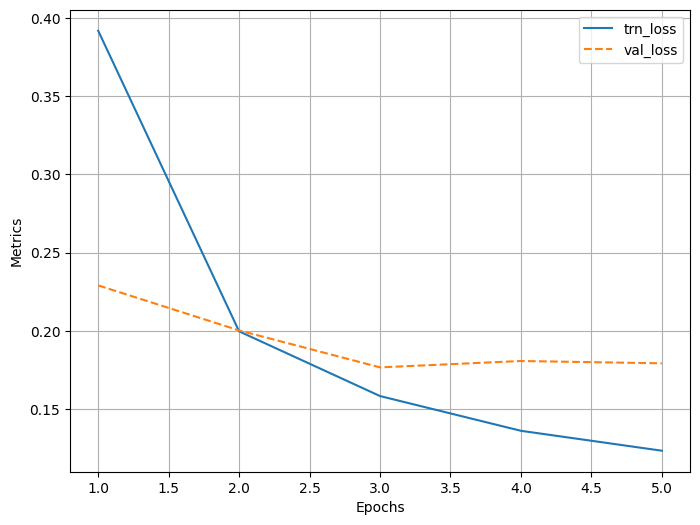

In [ ]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = [img.to(device) for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())

    loss.backward()
    optim.step()

    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = [img.to(device) for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())

    return loss, losses

# Initialize model and optimizer
model = get_model().to(device)
optim = torch.optim.SGD(
    model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9
)

# Training loop
n_epochs = 5
log = Report(n_epochs)

for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)

        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [
            losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
        ]

        log.record(
            e + (i + 1) / N,
            trn_loss=loss.item(),
            trn_loc_loss=loc_loss.item(),
            trn_regr_loss=regr_loss.item(),
            trn_loss_objectness=loss_objectness.item(),
            trn_loss_rpn_box_reg=loss_rpn_box_reg.item()
        )

    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)

        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [
            losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
        ]

        log.record(
            e + (i + 1) / N,
            val_loss=loss.item(),
            val_loc_loss=loc_loss.item(),
            val_regr_loss=regr_loss.item(),
            val_loss_objectness=loss_objectness.item(),
            val_loss_rpn_box_reg=loss_rpn_box_reg.item()
        )

    log.report_avgs(e + 1)

# Plot results
log.plot_epochs(['trn_loss', 'val_loss'])


- 1. Comment on the trn_loss line (training loss) trn_loss starts from quite high value (~ 0.39) and gradually decreases according to the epoch number. The first decrease in the Epoch shows the model that is quite fast. After Epoch 2, Trn_loss continues to decrease but the speed is slower → showing signs of convergence gradually. 
- 2. Comments on Val_loss (Validation Loss) Val_loss starts lower than trn_loss, tends to decrease in the first two epochs, but then fluctuates slightly around the value ~ 0.19. The slight oscillation in the 3-5 Epoch may be due to the light-might-mild adution model or high noise validation data.

- Train_batch (): Training function on a data batch.  
- Validate_batch (): Model assessment function on Batch Validation.  
- SGD Optimizer: Use SGD optimal algorithm with learning rate 0.005.  
- n_epochs = 5: Model training in 5 epochs.  
- Report: monitor the training and evaluation process.  
- log.plot_epochs (): Draw a chart of loss during training.

## 8. Output decoding and applying NMS

In [ ]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

- Decode_output helps extract Bounding Boxes, Labels and Scores from the model's output.  
- NMS (...): Apply Non-Maximum Suppression (NMS) to remove duplicated bounding boxes.

## 9. Check the model and display output

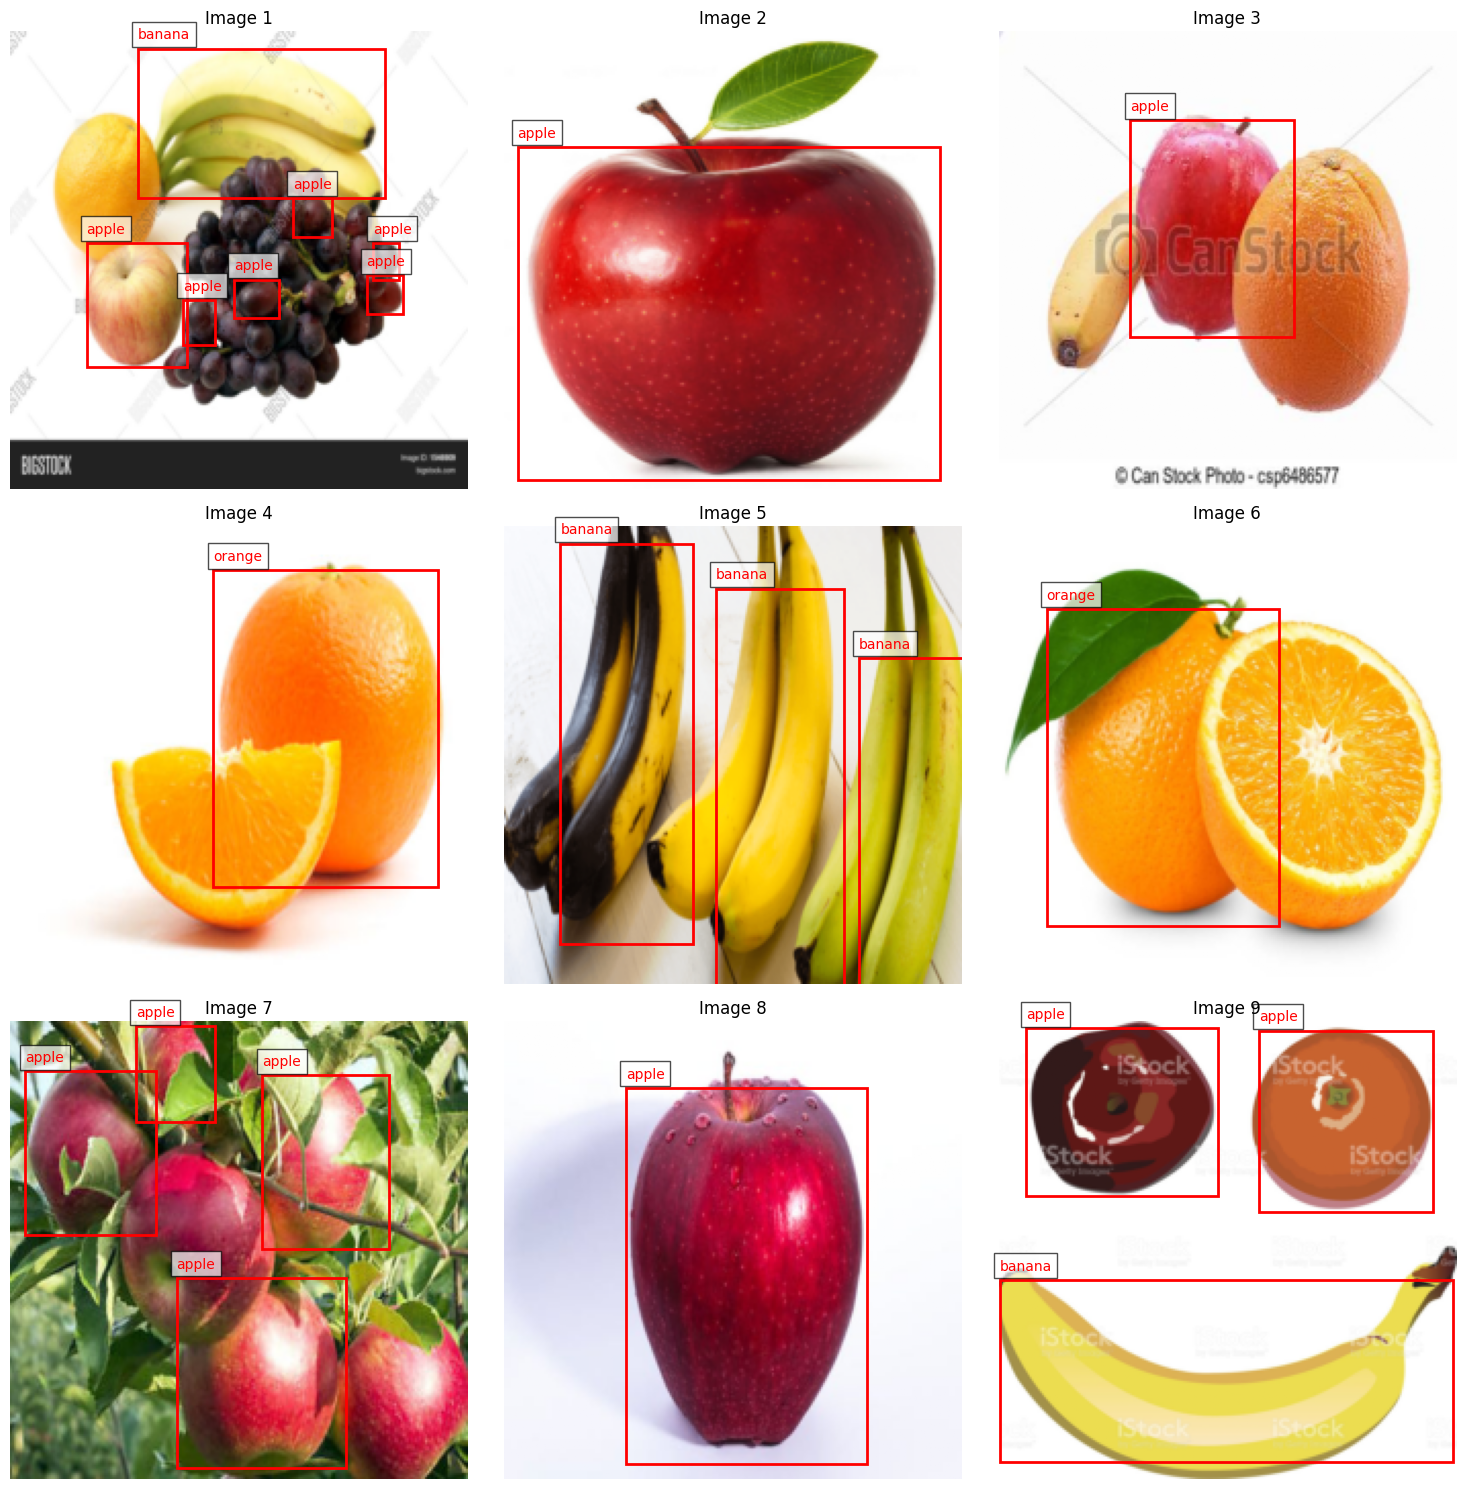

In [ ]:
model.eval()
num_images = 9  # Số lượng ảnh tối đa hiển thị
num_cols = 3    # Số cột trong lưới hiển thị
num_rows = (num_images + num_cols - 1) // num_cols  # Số hàng cần thiết

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, (images, targets) in enumerate(val_dl):
    if i * len(images) >= num_images:
        break
    images = [im for im in images]
    outputs = model(images)

    for j, output in enumerate(outputs):
        img_idx = i * len(outputs) + j
        if img_idx >= num_images:
            break

        bbs, confs, labels = decode_output(output)
        img = images[j].cpu().permute(1, 2, 0).numpy()

        ax = axes[img_idx]
        ax.imshow(img)
        ax.set_title(f"Image {img_idx + 1}")
        ax.axis("off")

        # Vẽ bounding boxes và nhãn
        for bb, label in zip(bbs, labels):
            x1, y1, x2, y2 = bb
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, edgecolor='red', linewidth=2))
            ax.text(x1, y1 - 5, label, color='red', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7))

# Ẩn các ô trống nếu tổng số ảnh nhỏ hơn số ô trong lưới
for k in range(img_idx + 1, num_rows * num_cols):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()